<a href="https://colab.research.google.com/github/softmurata/colab_notebooks/blob/main/animation/makeittalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/cedro3/MakeItTalk.git
%cd MakeItTalk/
!export PYTHONPATH=/content/MakeItTalk:$PYTHONPATH
!pip install -r requirements.txt
!pip install tensorboardX

In [6]:
!mkdir examples/dump
!mkdir examples/ckpt

mkdir: cannot create directory ‘examples/dump’: File exists


In [ ]:
!pip install gdown
!gdown -O examples/ckpt/ckpt_autovc.pth https://drive.google.com/uc?id=1ZiwPp_h62LtjU0DwpelLUoodKPR85K7x
!gdown -O examples/ckpt/ckpt_content_branch.pth https://drive.google.com/uc?id=1r3bfEvTVl6pCNw5xwUhEglwDHjWtAqQp
!gdown -O examples/ckpt/ckpt_speaker_branch.pth https://drive.google.com/uc?id=1rV0jkyDqPW-aDJcj7xSO6Zt1zSXqn1mu
!gdown -O examples/ckpt/ckpt_116_i2i_comb.pth https://drive.google.com/uc?id=1i2LJXKp-yWKIEEgJ7C6cE3_2NirfY_0a
!gdown -O examples/dump/emb.pickle https://drive.google.com/uc?id=18-0CYl5E6ungS3H4rRSHjfYvvm-WwjTI


In [7]:
!rm -rf /content/MakeItTalk/examples/ckpt/ckpt_116_i2i_comb.pth
!rm -rf /content/MakeItTalk/examples/ckpt/ckpt_autovc.pth

In [8]:
!cp /content/drive/MyDrive/makeittalkckpts/ckpt_116_i2i_comb.pth /content/MakeItTalk/examples/ckpt/ckpt_116_i2i_comb.pth
!cp /content/drive/MyDrive/makeittalkckpts/ckpt_autovc.pth  /content/MakeItTalk/examples/ckpt/ckpt_autovc.pth

In [1]:
%cd /content/MakeItTalk/

/content/MakeItTalk


In [7]:
#@title settings
# after inference with realistic vision, you should do following parts.
default_head_name = 'europe_girl_small'           # the image name (with no .jpg) to animate
ADD_NAIVE_EYE = True                 # whether add naive eye blink
CLOSE_INPUT_FACE_MOUTH = False       # if your image has an opened mouth, put this as True, else False
AMP_LIP_SHAPE_X = 2.                 # amplify the lip motion in horizontal direction
AMP_LIP_SHAPE_Y = 2.                 # amplify the lip motion in vertical direction
AMP_HEAD_POSE_MOTION = 0.7           # amplify the head pose motion (usually smaller than 1.0, put it to 0. for 

In [6]:
from PIL import Image
img = Image.open("/content/MakeItTalk/examples/europe_girl.jpg").resize((256, 256))
img.save("/content/MakeItTalk/examples/europe_girl_small.jpg")

In [ ]:
#@title create mp4
import sys
sys.path.append("thirdparty/AdaptiveWingLoss")
import os, glob
import numpy as np
import cv2
import argparse
from src.approaches.train_image_translation import Image_translation_block
import torch
import pickle
import face_alignment
from src.autovc.AutoVC_mel_Convertor_retrain_version import AutoVC_mel_Convertor
import shutil
import time
import util.utils as util
from scipy.signal import savgol_filter
from src.approaches.train_audio2landmark import Audio2landmark_model
 
 
parser = argparse.ArgumentParser()
parser.add_argument('--jpg', type=str, default='{}.jpg'.format(default_head_name))
parser.add_argument('--close_input_face_mouth', default=CLOSE_INPUT_FACE_MOUTH, action='store_true')
 
parser.add_argument('--load_AUTOVC_name', type=str, default='examples/ckpt/ckpt_autovc.pth')
parser.add_argument('--load_a2l_G_name', type=str, default='examples/ckpt/ckpt_speaker_branch.pth')
parser.add_argument('--load_a2l_C_name', type=str, default='examples/ckpt/ckpt_content_branch.pth') #ckpt_audio2landmark_c.pth')
parser.add_argument('--load_G_name', type=str, default='examples/ckpt/ckpt_116_i2i_comb.pth') #ckpt_image2image.pth') #ckpt_i2i_finetune_150.pth') #c
 
parser.add_argument('--amp_lip_x', type=float, default=AMP_LIP_SHAPE_X)
parser.add_argument('--amp_lip_y', type=float, default=AMP_LIP_SHAPE_Y)
parser.add_argument('--amp_pos', type=float, default=AMP_HEAD_POSE_MOTION)
parser.add_argument('--reuse_train_emb_list', type=str, nargs='+', default=[]) #  ['iWeklsXc0H8']) #['45hn7-LXDX8']) #['E_kmpT-EfOg']) #'iWeklsXc0H8', '29k8RtSUjE0', '45hn7-LXDX8',
parser.add_argument('--add_audio_in', default=False, action='store_true')
parser.add_argument('--comb_fan_awing', default=False, action='store_true')
parser.add_argument('--output_folder', type=str, default='examples')
 
parser.add_argument('--test_end2end', default=True, action='store_true')
parser.add_argument('--dump_dir', type=str, default='', help='')
parser.add_argument('--pos_dim', default=7, type=int)
parser.add_argument('--use_prior_net', default=True, action='store_true')
parser.add_argument('--transformer_d_model', default=32, type=int)
parser.add_argument('--transformer_N', default=2, type=int)
parser.add_argument('--transformer_heads', default=2, type=int)
parser.add_argument('--spk_emb_enc_size', default=16, type=int)
parser.add_argument('--init_content_encoder', type=str, default='')
parser.add_argument('--lr', type=float, default=1e-3, help='learning rate')
parser.add_argument('--reg_lr', type=float, default=1e-6, help='weight decay')
parser.add_argument('--write', default=False, action='store_true')
parser.add_argument('--segment_batch_size', type=int, default=1, help='batch size')
parser.add_argument('--emb_coef', default=3.0, type=float)
parser.add_argument('--lambda_laplacian_smooth_loss', default=1.0, type=float)
parser.add_argument('--use_11spk_only', default=False, action='store_true')
parser.add_argument('-f')
 
opt_parser = parser.parse_args()
 
# load the image and detect its landmark
img =cv2.imread('examples/' + opt_parser.jpg)
predictor = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, device='cpu', flip_input=True)
shapes = predictor.get_landmarks(img)
if (not shapes or len(shapes) != 1):
    print('Cannot detect face landmarks. Exit.')
    exit(-1)
shape_3d = shapes[0]
 
if(opt_parser.close_input_face_mouth):
    util.close_input_face_mouth(shape_3d)
 
# Simple manual adjustment to landmarks in case FAN is not accurate, e.g.
shape_3d[48:, 0] = (shape_3d[48:, 0] - np.mean(shape_3d[48:, 0])) * 1.05 + np.mean(shape_3d[48:, 0]) # wider lips
shape_3d[49:54, 1] += 0.           # thinner upper lip
shape_3d[55:60, 1] -= 1.           # thinner lower lip
shape_3d[[37,38,43,44], 1] -=2.    # larger eyes
shape_3d[[40,41,46,47], 1] +=2.    # larger eyes
 
shape_3d, scale, shift = util.norm_input_face(shape_3d)
 
 
# Generate input data for inference based on uploaded audio MakeItTalk/examples/*.wav
au_data = []
au_emb = []
ains = glob.glob1('examples', '*.wav')
ains = [item for item in ains if item is not 'tmp.wav']
ains.sort()
for ain in ains:
    os.system('ffmpeg -y -loglevel error -i examples/{} -ar 16000 examples/tmp.wav'.format(ain))
    shutil.copyfile('examples/tmp.wav', 'examples/{}'.format(ain))
 
    # au embedding
    from thirdparty.resemblyer_util.speaker_emb import get_spk_emb
    me, ae = get_spk_emb('examples/{}'.format(ain))
    au_emb.append(me.reshape(-1))
 
    print('Processing audio file', ain)
    c = AutoVC_mel_Convertor('examples')
 
    au_data_i = c.convert_single_wav_to_autovc_input(audio_filename=os.path.join('examples', ain),
           autovc_model_path=opt_parser.load_AUTOVC_name)
    au_data += au_data_i
if(os.path.isfile('examples/tmp.wav')):
    os.remove('examples/tmp.wav')
 
# landmark fake placeholder
fl_data = []
rot_tran, rot_quat, anchor_t_shape = [], [], []
for au, info in au_data:
    au_length = au.shape[0]
    fl = np.zeros(shape=(au_length, 68 * 3))
    fl_data.append((fl, info))
    rot_tran.append(np.zeros(shape=(au_length, 3, 4)))
    rot_quat.append(np.zeros(shape=(au_length, 4)))
    anchor_t_shape.append(np.zeros(shape=(au_length, 68 * 3)))
 
if(os.path.exists(os.path.join('examples', 'dump', 'random_val_fl.pickle'))):
    os.remove(os.path.join('examples', 'dump', 'random_val_fl.pickle'))
if(os.path.exists(os.path.join('examples', 'dump', 'random_val_fl_interp.pickle'))):
    os.remove(os.path.join('examples', 'dump', 'random_val_fl_interp.pickle'))
if(os.path.exists(os.path.join('examples', 'dump', 'random_val_au.pickle'))):
    os.remove(os.path.join('examples', 'dump', 'random_val_au.pickle'))
if (os.path.exists(os.path.join('examples', 'dump', 'random_val_gaze.pickle'))):
    os.remove(os.path.join('examples', 'dump', 'random_val_gaze.pickle'))
 
with open(os.path.join('examples', 'dump', 'random_val_fl.pickle'), 'wb') as fp:
    pickle.dump(fl_data, fp)
with open(os.path.join('examples', 'dump', 'random_val_au.pickle'), 'wb') as fp:
    pickle.dump(au_data, fp)
with open(os.path.join('examples', 'dump', 'random_val_gaze.pickle'), 'wb') as fp:
    gaze = {'rot_trans':rot_tran, 'rot_quat':rot_quat, 'anchor_t_shape':anchor_t_shape}
    pickle.dump(gaze, fp)
 
 
# Audio-to-Landmarks prediction    
!pwd
model = Audio2landmark_model(opt_parser, jpg_shape=shape_3d)
if(len(opt_parser.reuse_train_emb_list) == 0):
    model.test(au_emb=au_emb)
else:
    model.test(au_emb=None)
 
 
# Natural face animation via Image-to-image translation    
fls = glob.glob1('examples', 'pred_fls_*.txt')
fls.sort()
 
for i in range(0,len(fls)):
    fl = np.loadtxt(os.path.join('examples', fls[i])).reshape((-1, 68,3))
    fl[:, :, 0:2] = -fl[:, :, 0:2]
    fl[:, :, 0:2] = fl[:, :, 0:2] / scale - shift
 
    if (ADD_NAIVE_EYE):
        fl = util.add_naive_eye(fl)
 
    # additional smooth
    fl = fl.reshape((-1, 204))
    fl[:, :48 * 3] = savgol_filter(fl[:, :48 * 3], 15, 3, axis=0)
    fl[:, 48*3:] = savgol_filter(fl[:, 48*3:], 5, 3, axis=0)
    fl = fl.reshape((-1, 68, 3))
 
    ''' Imag2image translation '''
    model = Image_translation_block(opt_parser, single_test=True)
    with torch.no_grad():
        model.single_test(jpg=img, fls=fl, filename=fls[i], prefix=opt_parser.jpg.split('.')[0])
        print('finish image2image gen')
    os.remove(os.path.join('examples', fls[i]))

In [9]:
#@title display video
from IPython.display import HTML
from base64 import b64encode
 
for ain in ains:
  OUTPUT_MP4_NAME = '{}_pred_fls_{}_audio_embed.mp4'.format(
    opt_parser.jpg.split('.')[0],
    ain.split('.')[0]
    )
  mp4 = open('examples/{}'.format(OUTPUT_MP4_NAME),'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
 
  print('Display animation: examples/{}'.format(OUTPUT_MP4_NAME))
  display(HTML("""
  <video width=600 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url))

Display animation: examples/europe_girl_small_pred_fls_caffe_audio_embed.mp4


In [ ]:
#@title stable diffusion(realistic vision) + make it talk

In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git gradio

In [ ]:
!pip install transformers

In [ ]:
!pip install accelerate

In [9]:
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, DPMSolverMultistepScheduler
import gradio as gr
import torch
from PIL import Image

model_id = 'SG161222/Realistic_Vision_V1.4'
prefix = 'RAW photo,'
     
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
  model_id,
  torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
  scheduler=scheduler)

pipe_i2i = StableDiffusionImg2ImgPipeline.from_pretrained(
  model_id,
  torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
  scheduler=scheduler)

if torch.cuda.is_available():
  pipe = pipe.to("cuda")
  pipe_i2i = pipe_i2i.to("cuda")


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [10]:
guidance=7.5 #@param {type:"number"}
steps=25 #@param {type:"number"}
width=512 #@param {type:"number"}
height=512 #@param {type:"number"}
seed=0 #@param {type:"number"}
strength=0.5 #@param {type:"number"}
prompt="a close up portrait face photo of cute 5 y.o european girl in casual clothes, long haircut, pale skin, slim body, background is hawaii beach, (high detailed skin:1.2), 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3" #@param {type:"string"}
neg_prompt="(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck" #@param {type:"string"}
auto_prefix=False

In [11]:
generator = torch.Generator('cuda').manual_seed(seed) if seed != 0 else None
prompt = f"{prefix} {prompt}" if auto_prefix else prompt

  0%|          | 0/25 [00:00<?, ?it/s]

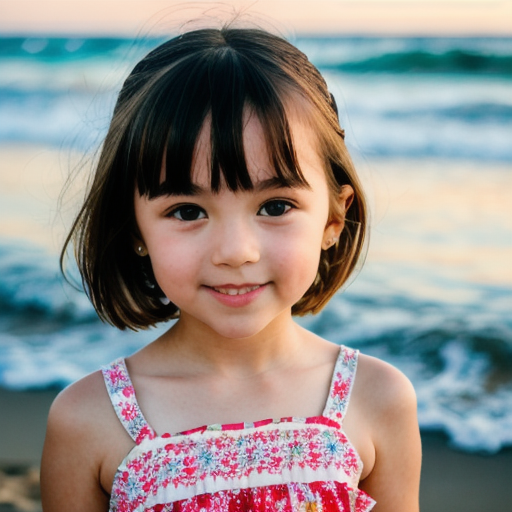

In [12]:
# text2image
result = pipe(
      prompt,
      negative_prompt = neg_prompt,
      num_inference_steps = int(steps),
      guidance_scale = guidance,
      width = width,
      height = height,
      generator = generator)

display(result.images[0])
result.images[0].convert("RGB").save("europe_girl.jpg")

  0%|          | 0/12 [00:00<?, ?it/s]

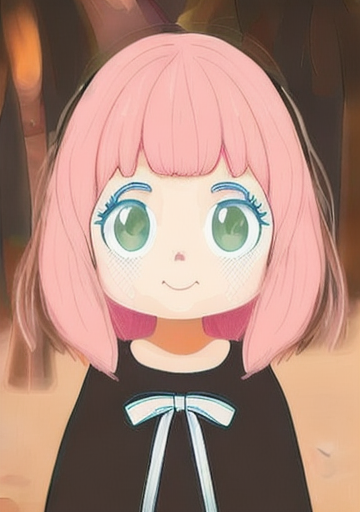

In [25]:
# image2image
img = Image.open("/content/anya.jpeg")
ratio = min(height / img.height, width / img.width)
img = img.resize((int(img.width * ratio), int(img.height * ratio)), Image.LANCZOS)
result = pipe_i2i(
        prompt,
        negative_prompt = neg_prompt,
        image = img,
        num_inference_steps = int(steps),
        strength = strength,
        guidance_scale = guidance,
        generator = generator)
        
display(result.images[0])

In [ ]:
#@title realistic vision automatic web111
!curl -Lo memfix.zip https://github.com/nolanaatama/sd-webui/raw/main/memfix.zip
!unzip /content/memfix.zip
!apt install -qq libunwind8-dev
!dpkg -i *.deb
%env LD_PRELOAD=libtcmalloc.so
!rm *
!pip install --upgrade fastapi==0.90.1
!git clone https://github.com/AUTOMATIC1111/stable-diffusion-webui
!git clone https://github.com/nolanaatama/sd-webui-tunnels /content/stable-diffusion-webui/extensions/sd-webui-tunnels
!git clone https://github.com/Mikubill/sd-webui-controlnet /content/stable-diffusion-webui/extensions/sd-webui-controlnet
!git clone https://github.com/fkunn1326/openpose-editor /content/stable-diffusion-webui/extensions/openpose-editor
!git clone https://github.com/yfszzx/stable-diffusion-webui-images-browser /content/stable-diffusion-webui/extensions/stable-diffusion-webui-images-browser
!git clone https://github.com/DominikDoom/a1111-sd-webui-tagcomplete /content/stable-diffusion-webui/extensions/a1111-sd-webui-tagcomplete
# Model Code
!curl -Lo /content/stable-diffusion-webui/models/Stable-diffusion/realisticvisionv1.3.ckpt https://huggingface.co/nolanaatama/rv13/resolve/main/rv13.ckpt
# ControlNet
!curl -Lo /content/stable-diffusion-webui/extensions/sd-webui-controlnet/models/control_canny.safetensors https://huggingface.co/webui/ControlNet-modules-safetensors/resolve/main/control_canny-fp16.safetensors
!curl -Lo /content/stable-diffusion-webui/extensions/sd-webui-controlnet/models/control_depth.safetensors https://huggingface.co/webui/ControlNet-modules-safetensors/resolve/main/control_depth-fp16.safetensors
!curl -Lo /content/stable-diffusion-webui/extensions/sd-webui-controlnet/models/control_hed-fp16.safetensors https://huggingface.co/webui/ControlNet-modules-safetensors/resolve/main/control_hed-fp16.safetensors
!curl -Lo /content/stable-diffusion-webui/extensions/sd-webui-controlnet/models/control_mlsd-fp16.safetensors https://huggingface.co/webui/ControlNet-modules-safetensors/resolve/main/control_mlsd-fp16.safetensors
!curl -Lo /content/stable-diffusion-webui/extensions/sd-webui-controlnet/models/control_normal-fp16.safetensors https://huggingface.co/webui/ControlNet-modules-safetensors/resolve/main/control_normal-fp16.safetensors
!curl -Lo /content/stable-diffusion-webui/extensions/sd-webui-controlnet/models/control_openpose-fp16.safetensors https://huggingface.co/webui/ControlNet-modules-safetensors/resolve/main/control_openpose-fp16.safetensors
!curl -Lo /content/stable-diffusion-webui/extensions/sd-webui-controlnet/models/control_scribble-fp16.safetensors https://huggingface.co/webui/ControlNet-modules-safetensors/resolve/main/control_scribble-fp16.safetensors
!curl -Lo /content/stable-diffusion-webui/extensions/sd-webui-controlnet/models/control_seg-fp16.safetensors https://huggingface.co/webui/ControlNet-modules-safetensors/resolve/main/control_seg-fp16.safetensors
import shutil
shutil.rmtree('/content/stable-diffusion-webui/embeddings')
%cd /content/stable-diffusion-webui
!git checkout 0cc0ee1
!git clone https://huggingface.co/nolanaatama/embeddings
# Web UI tunnel (use cloudflare by default)
!COMMANDLINE_ARGS="--disable-safe-unpickle --no-half-vae --xformers --reinstall-xformers --enable-insecure-extension- --gradio-queue --cloudflared" REQS_FILE="requirements.txt" python launch.py
# Change '--cloudflared' to '--share' on the COMMANDLINE_ARGS line above to use gradio tunnel
# Change '--cloudflared' to '--localhostrun' to use localhost.run tunnel
# Change '--cloudflared' to '--remotemoe' to use remotemoe tunnel